In [2]:
import pandas as pd
import datetime as dt
from datetime import datetime
import time
import matplotlib.pyplot as plt

In [126]:
df = pd.read_csv('DesMoines_GDD_PredictedGDD.csv')

product = "soy"
COMMODITIES = {"soy" : "S 1 (Soy)", "corn" : "C 1 (Corn)"}

real_gdd = pd.read_csv('36 month Degree day/KDSM_CDD_50F.csv')
real_gdd = real_gdd.drop([real_gdd.columns[2]], axis=1)
real_gdd["Date"] = pd.to_datetime(real_gdd["Date"])
real_gdd["CDD 50"] = real_gdd["CDD 50"].clip(0, 36)

def convert_date_string(date_str):
    time_struct = time.strptime(date_str, '%m/%d/%y')
    dt_obj = datetime(*time_struct[:6])
    new_date_str = dt_obj.strftime('%m/%d/%y')
    return new_date_str
df['Date'] = df['Date'].apply(lambda x: convert_date_string(x))
corn = pd.read_excel('commodity_prices.xlsx', sheet_name=COMMODITIES[product])[['Date','Last Price']]
# corn = pd.read_excel('commodity_prices.xlsx', sheet_name='S 1 (Soy)')[['Date','Last Price']]

corn.rename(columns={'Last Price':'Corn'}, inplace=True)
def converter(s):
    parts = s.split()
    integer_part = int(parts[0])
    fraction_part = eval(parts[1])
    result = integer_part + fraction_part
    return result
corn['Corn'] = corn['Corn'].apply(lambda x: converter(x) if ' ' in str(x) else x)
corn['Date'] = corn['Date'].apply(lambda x: str(x))
def convert_date_string(date_str):
    dt_obj = dt.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
    new_date_str = dt_obj.strftime('%m/%d/%y')
    return new_date_str
corn['Date'] = corn['Date'].apply(lambda x: convert_date_string(x))

df = pd.merge(df, corn, on='Date', how='inner')
df["Date"] = pd.to_datetime(df['Date'])
df = pd.merge(df, real_gdd, on='Date', how='inner')
df["CDD 50"] = df["CDD 50"].shift(1)


In [72]:
df

,Date,Degrees Above 50,Predicted GDD,Corn,CDD 50
0,2020-02-03,0.0,0.0,877.00,NaN
1,2020-02-04,0.0,0.0,879.50,0.0
2,2020-02-05,0.0,0.0,880.00,0.0
3,2020-02-06,0.0,0.0,881.00,0.0
4,2020-02-07,0.0,0.0,882.00,0.0
...,...,...,...,...,...
767,2023-02-15,0.0,0.0,1525.75,0.0
768,2023-02-16,0.0,0.0,1526.50,0.0
769,2023-02-17,0.0,0.0,1527.25,0.0
770,2023-02-21,0.0,0.0,1548.75,0.0


In [127]:
df['Corn_returns'] = df['Corn'].pct_change()
df['Corn_cumulative_returns'] = (1 + df['Corn_returns']).cumprod()
def trader(MA_window,stds,corr_window,corr_threshold,df=df):
    # df['Predicted_GDD_MA'] = df['Predicted GDD'].rolling(MA_window).mean()
    # df["Month"] = df["Date"].dt.month;
    # df = df.loc[df["Month"].isin([5,6,7,8,9])]
    # df.drop(["Month"], axis=1, inplace=True)


    df['Predicted_GDD_MA'] = (df['CDD 50'].rolling(MA_window - 1).sum() + df['Predicted GDD']) / MA_window
    df['upper'] = df['Predicted_GDD_MA'] + stds * df['CDD 50'].rolling(MA_window).std()
    df['lower'] = df['Predicted_GDD_MA'] - stds * df['CDD 50'].rolling(MA_window).std()
    df['correlation'] = df['Corn_returns'].rolling(corr_window).corr(df['Predicted GDD'])
    df['signal'] = 0
    df.loc[df['Predicted GDD'] > df['upper'], 'signal'] = -1
    df.loc[df['Predicted GDD'] < df['lower'], 'signal'] = 1
    df.loc[abs(df['correlation']) < abs(corr_threshold), 'signal'] = 0
    df['signal'] = df['signal'].shift(1)
    df['signal returns'] = df['signal'] * df['Corn_returns']
    df['signal cumulative returns'] = (1 + df['signal returns']).cumprod()  
    # return df
    # return df[['Corn_cumulative_returns', 'signal cumulative returns']].plot()
    return list(df['signal cumulative returns'])[-1]

In [153]:
MAs = [x*5 for x in range(1,21)]
stds = [.1,.25,.5,.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]
corr_windows = [5,10,15,20,25,30,35,40,45,50]
corr_thresholds = [-.75, -.5,-.25,-.1,0,.1,.25,.5,.75]
# try every combination of parameters to return the best combination
best = 0
res = []
# try every combination of parameters to return the best combination
best = 0
for MA in MAs:
    for std in stds:
        for corr_window in corr_windows:
            for corr_threshold in corr_thresholds:
                result = trader(MA,std,corr_window,corr_threshold)
                if result > best:
                    best = result
                    best_params = [MA,std,corr_window,corr_threshold]
# for MA in MAs:
#     result = trader(int(MA),0.1,int(MA),-0.5)
#     res.append([MA, result])

In [ ]:
plt.plot([x[0] for x in res], [x[1] for x in res])
plt.plot([x[0] for x in res], [1.779538 for x in res])
ax = plt.gca()
_ = ax.legend(["window sizes", f"long {product}"])
_ = ax.set_xlabel("window size")
_ = ax.set_ylabel("total return")


In [154]:
best_params



[100, 0.25, 10, -0.1]

Date                         2023-02-22 00:00:00
Degrees Above 50                             0.0
Predicted GDD                                0.0
Corn                                      1539.5
CDD 50                                       0.0
Corn_returns                           -0.005973
Corn_cumulative_returns                 1.755416
Predicted_GDD_MA                           2.114
upper                                   3.180071
lower                                   1.047929
correlation                                  NaN
signal                                       1.0
signal returns                         -0.005973
signal cumulative returns               2.827485
Name: 771, dtype: object
(555, 14)


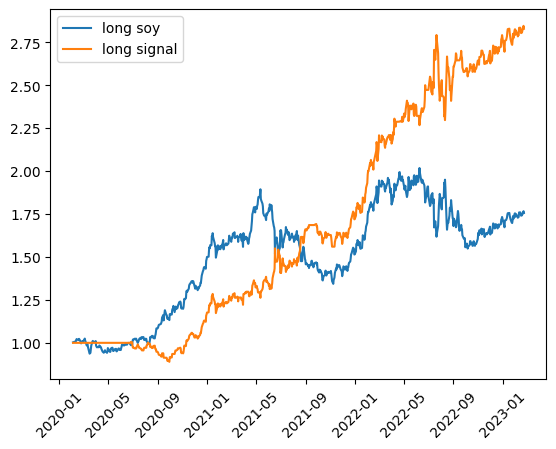

In [155]:
trader(MA_window=100,stds=.25,corr_window=10,corr_threshold=-0.1)
# trader(MA_window=100,stds=0.1,corr_window=30,corr_threshold=-0.1)

graph = plt.plot(df["Date"], df[['Corn_cumulative_returns', 'signal cumulative returns']])
ax = plt.gca()
_ = ax.legend([f"long {product}", "long signal"])
# _ = ax.set_xticks(ax.get_xticks()[::182])
_ = plt.xticks(rotation=45)
print(df.iloc[-1])
print(df.loc[df["signal"] != 0].shape)
# df.shape
